# 图像特征图的提取

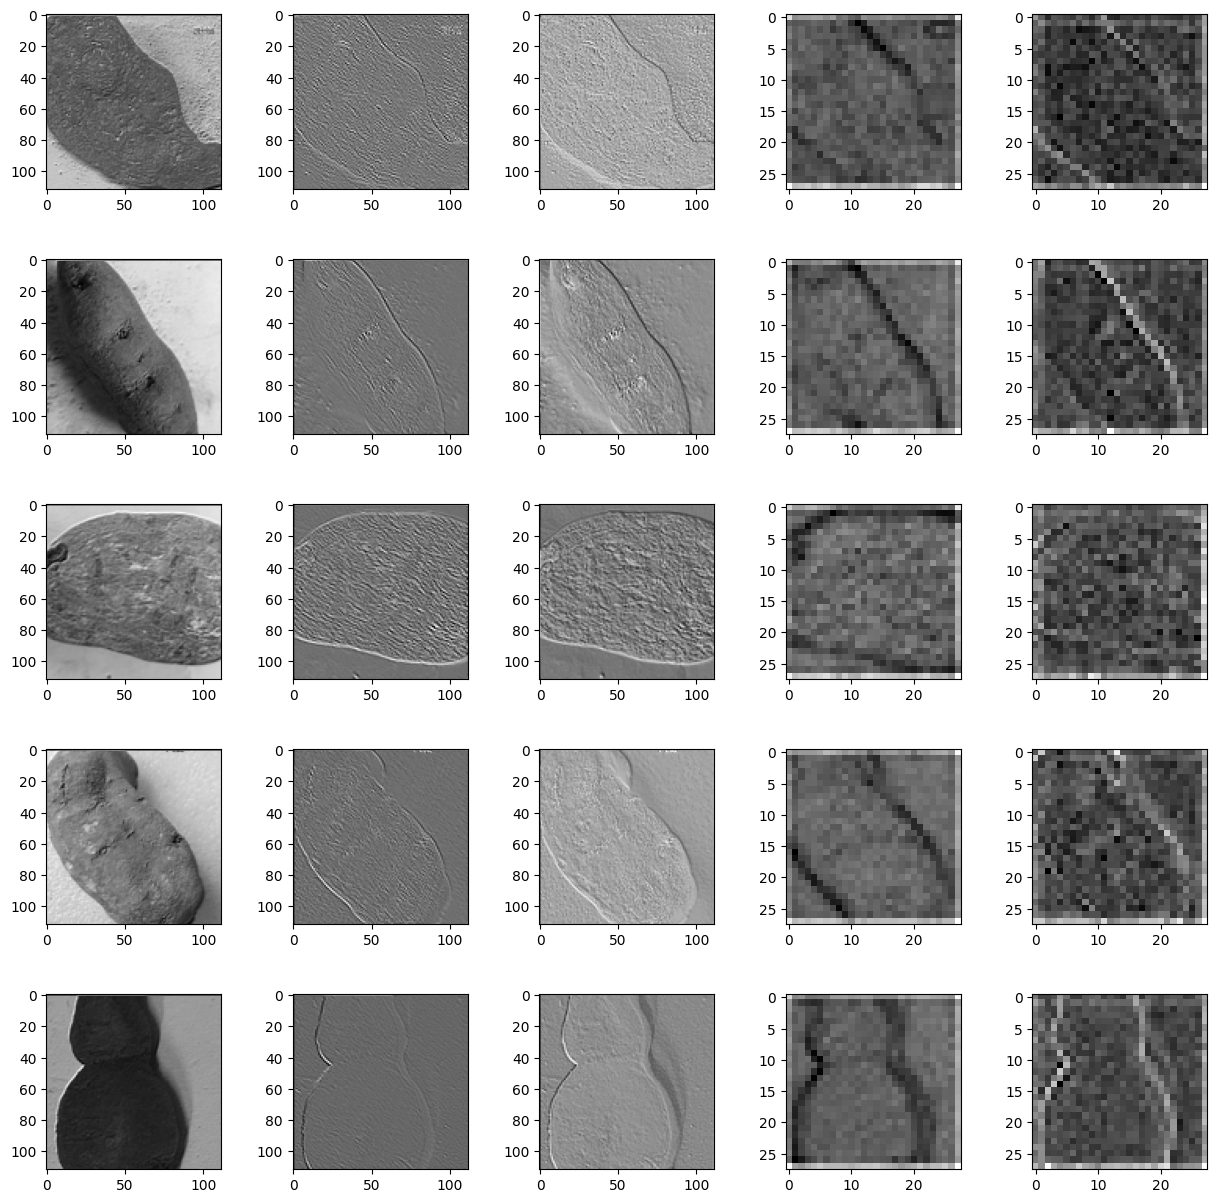

In [42]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import io
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load(r"D:\SanYeQing_Project\wht_sanyeqing_image-Classification\model_zheng_path\model_cpu_97.18.pth", map_location=device)
model.to(device)
model.eval()

# 存储每一层的输出
features = {}

# 创建一个钩子函数，用于保存每一层的输出
def hook(module, input, output):
    global features
    # 这里我们只保存来自卷积层并且可以直接可视化的2D和3D特征图
    if isinstance(module, torch.nn.modules.conv._ConvNd) and (len(output.shape) == 4 or len(output.shape) == 3):
        layer_name = str(module)
        features[layer_name] = output.detach()

# 为模型的每一层注册钩子
for name, layer in model.named_modules():
    layer.register_forward_hook(hook)

# 加载并预处理图像
def transform_image(image_bytes):
    img_size = 224
    my_transforms = transforms.Compose([transforms.Resize(int(img_size * 1.143)),
                                        transforms.CenterCrop(img_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    image = Image.open(io.BytesIO(image_bytes))
    if image.mode != "RGB":
        image = image.convert("RGB")
    return my_transforms(image).unsqueeze(0).to(device)

# 加载图像
image_paths = [r"D:\微信图片_20240610010741.png",r"D:\微信图片_20240610010940.png", r"D:\微信图片_20240610005901.png",r"D:\微信图片_20240610010314.png",r"D:\微信图片_20240610010543.png"
               # 更多的图像路径
              ]
images = []
for path in image_paths:
    with open(path, 'rb') as f:
        image_bytes = f.read()
    images.append(transform_image(image_bytes))

# 通过模型传递一个图像以获取所有可以显示的层
output = model(images[0])
displayable_layers = [name for name, feature in features.items() if len(feature.shape) == 4 or len(feature.shape) == 3]

# 按照你的需求选择层
selected_layers = [displayable_layers[0]] +displayable_layers[2:4] + displayable_layers[13:15] # 这里假设你的模型有至少5个可以显示的层

# 创建一个新的大图并添加子图
fig, axs = plt.subplots(len(images), len(selected_layers), figsize=(15, 15))

# 遍历每个图像并显示特征图
for img_idx, image in enumerate(images):
    # 清空特征字典
    features.clear()

    # 通过模型传递图像
    output = model(image)

    # 使用之前选择的层
    selected_features = [(name, features[name]) for name in selected_layers]

    # 调整子图之间的间距
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # 此时，selected_features 包含了被选择的特征图
    for i, (name, feature) in enumerate(selected_features):
        feature = feature.cpu().squeeze()
        if len(feature.shape) == 3:
            feature = feature.permute(1, 2, 0)
            axs[img_idx, i].imshow(feature.mean(2).numpy(), cmap='gray')
        elif len(feature.shape) == 2:
            axs[img_idx, i].imshow(feature.numpy(), cmap='gray')

plt.show()


# 数据扩增图像展示

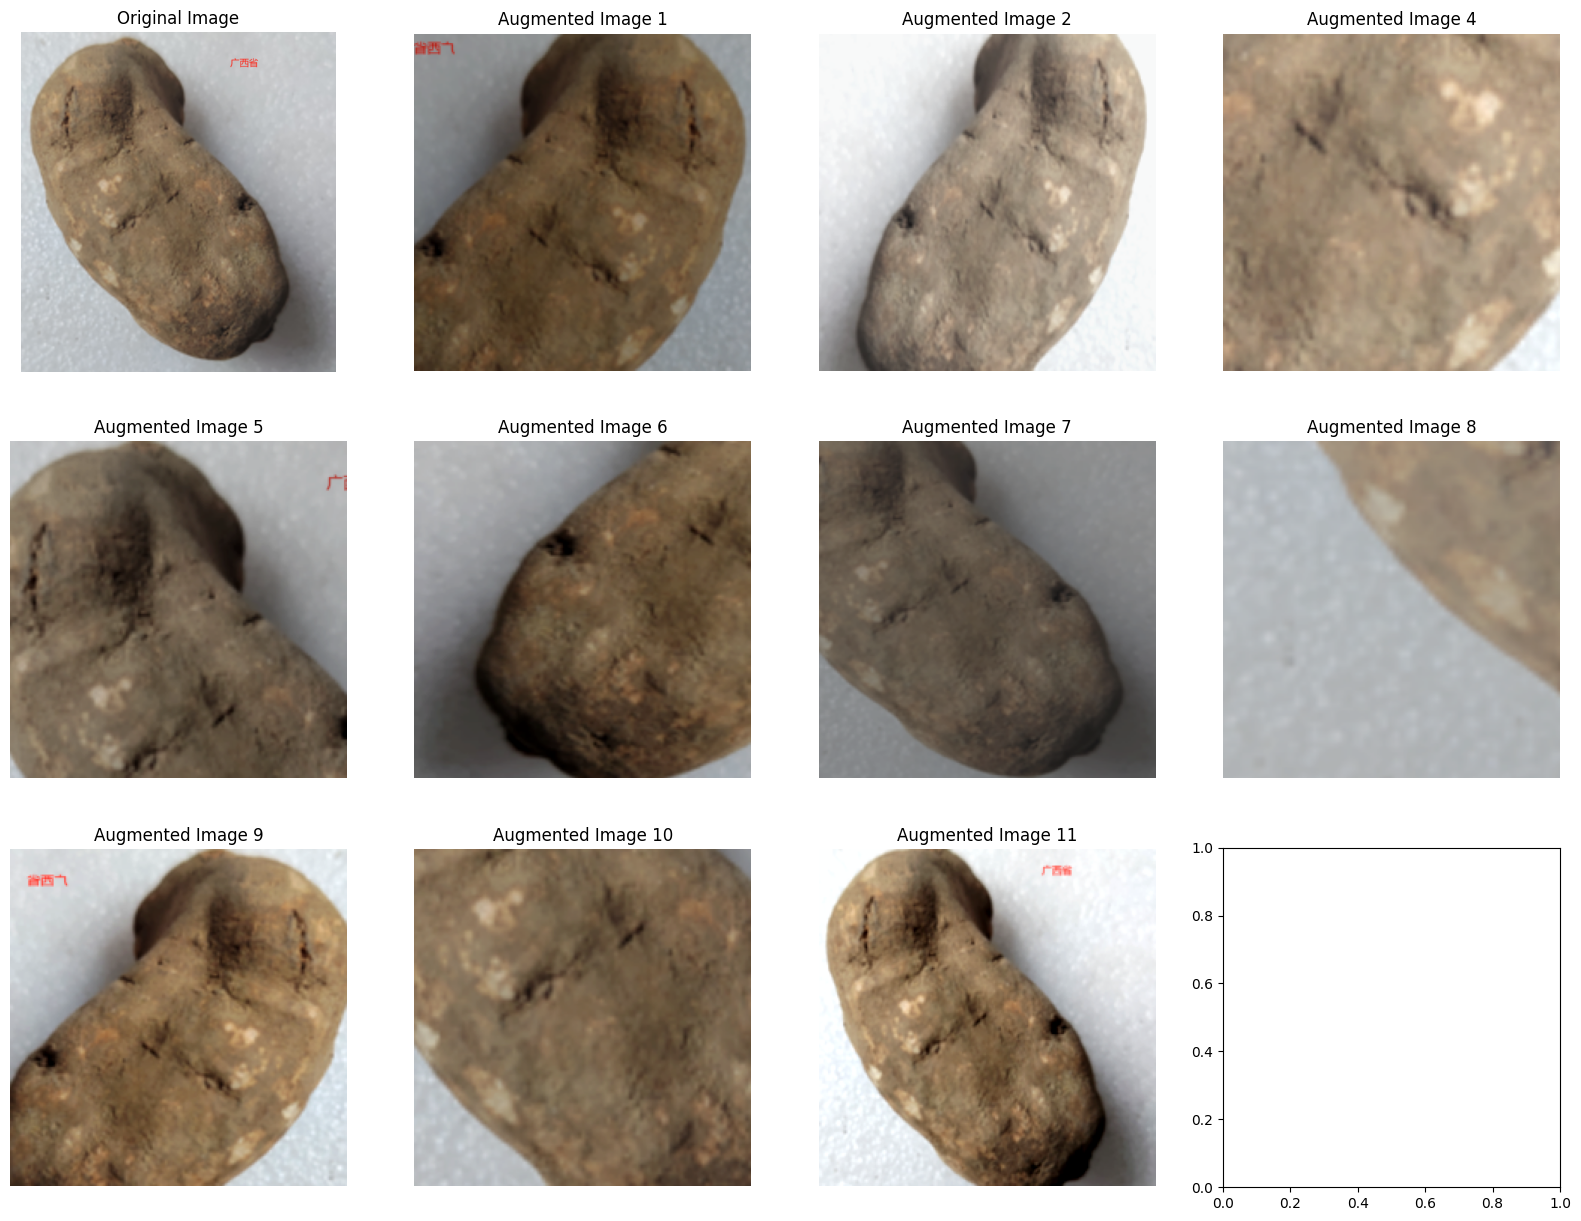

In [1]:
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

# 加载图像
image = Image.open(r"D:\微信图片_20240610010314.png").convert('RGB')

# 定义数据增强操作
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

# 创建一个新的大图并添加子图
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# 显示原始图像
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# 生成11张增强后的图像
for i in range(11):
    row = i // 4  # 计算当前图像所在的行
    col = (i % 4) + 1 if i < 3 else (i % 4) # 计算当前图像所在的列
    # 应用数据增强操作并将张量转换为numpy数组
    augmented_image = transform_train(image).permute(1, 2, 0).numpy()
    # 因为Normalize操作，所以需要将图像数据转回0-1范围
    augmented_image = (augmented_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    axs[row, col].imshow(augmented_image.clip(0, 1))  # clip to ensure image range is within 0-1
    axs[row, col].set_title('Augmented Image {}'.format(i+1))
    axs[row, col].axis('off')

plt.show()
